##### Tekijän nimi: Emil Jousimaa
##### Säpo: emil.jousimaa@tuni.fi

# JODA Kevät 2023 Datatiedeprojektipohja

Tämä datatiedeprojekti toimii harjoitustyönä Johdatus Datatieteeseen– opintojakson kevään 2023 toteutukselle. Projektin aiheena on tarkastella kuvitteellisen puhelinyhtiön asiakaspoistumaa, ja ennustaa sitä. Tarkoituksena on aluksi luoda ymmärrystä dataan, ja jalostaa sitä, jotta saataisiin luotua jossain määrin luotettava poistumaa ennustava koneoppimismalli. Tavoitteena on myös ennustaa poistumaa useamman mallin avulla ja verrata niiden suorituskykyä.

    Työn vaiheet:
1. Luetaan data, ja esikäsitellään sitä
2. Luodaan ymmärrystä dataan visualisointien avulla
3. Jalostetaan dataa
4. Koulutetaan koneoppimismallit
5. Analysoidaan tuloksia.

### Datan lukeminen sekä esikäsittely

Luetaan data, tarkastellaan sitä ja tehdään alustavaa esikäsittelyä.

In [1]:
# Importit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mutual_info_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from imblearn.over_sampling import SMOTE

# Luetaan data
df_original = pd.read_csv("TelcoData.csv")

df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [2]:
# Tarkastellaan kunkin attribuutin uniikkien arvojen lukumääriä
df_original.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

Huomataan, että TotalCharges–sarakkeessa on 6530 erilaista arvoa, mutta silti sen datatyyppi on "object". Lisäksi, sen tarkoitus on kuvata kokonaissummaa, joka asiakkaalta on veloitettu asiakassuhteen aikana. Voidaan siis päätellä, että se olisi syytä muuttaa numeeriseksi. 

In [3]:
# Muodostetaan kopio alkuperäisestä dataframesta, jotta tarvittaessa voidaan vielä palata alkuperäiseen dataframeen.
df = df_original.copy()

df["TotalCharges"] = df["TotalCharges"].str.strip()
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


TotalCharges–sarakkeen tyyppi on nyt oikea, mutta nyt huomataan, että sarakkeeseen on ilmestynyt null-arvoja. Rivit voisi vain suoraan poistaa, mutta mielenkiinnon vuoksi tutkitaan, mikä null-arvojen ilmestymisen olisi voinut aiheuttaa. Järjestetään alkuperäisen dataframen TotalCharges–sarakkeen arvot nousevaan järjestykseen, tulostetaan niistä 20 ensimmäistä ja katsotaan löytyykö ongelma sieltä.

In [4]:
print(df_original["TotalCharges"].sort_values().head(20).values)

[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '100.2' '100.25' '100.35'
 '100.4' '100.8' '100.9' '1001.2' '1001.5' '1003.05']


Tulosteesta huomataan, että TotalCharges–sarakkeen ollessa object-muotoinen, sieltä löytyy arvoja, jotka ovat pelkkiä välilyöntejä. Tämän takia ne eivät näkyneet null-arvoina aiemmin, mutta strip()–metodin ja sarakkeen datatyypin numeeriseksi muuttamisen jälkeen arvoista tulee NaN-arvoja, mikä voidaan todeta tulostamalla muokatun dataframen järjestetyn TotalCharges–sarakkeen viimeisiä arvoja näkyviin.

In [5]:
print(df["TotalCharges"].sort_values().tail(20).values)

[8496.7  8529.5  8543.25 8547.15 8564.75 8594.4  8670.1  8672.45 8684.8
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan]


Korvataan nan-arvot TotalCharges–sarakkeen mediaanilla.

In [6]:
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Nyt datatyypit näyttävät oikeilta ja null-arvoja ei näy enää. Tutkitaan seuraavaksi työkirjan kohdemuuttujaa eli asiakaspoistumaa.

In [7]:
df["Churn"].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

Huomataan, että noin 27% asiakkaista on poistunut. Epätasainen jakauma ennustettavassa muuttujassa aiheuttaa luokitteluongelman, mikä voi heikentää myöhemmin tehtävän koneoppimismallin tarkkuutta. Tämä huomioidaan ja korjataan ennen kuin koneoppimismalli koulutetaan.

### Datan visualisointi

Luodaan ymmärrystä dataan visualisoimalla sitä. Tarkoituksena olisi saada alustava käsitys siitä, mitkä tekijät vaikuttavat asiakaspoistumaan.

##### Asiakkaiden demografiset tiedot

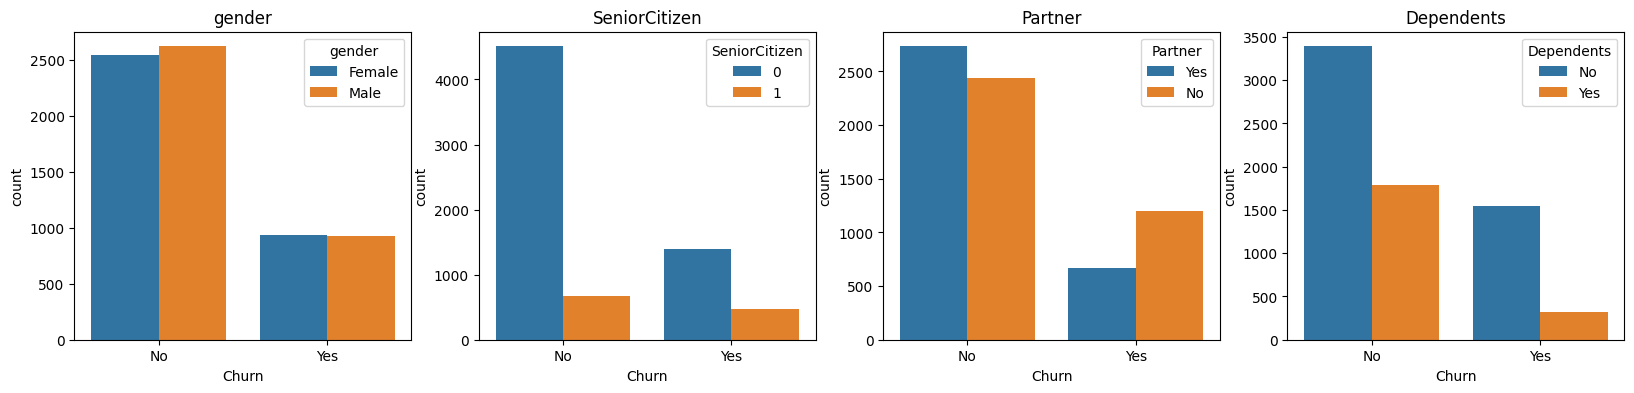

In [8]:
# Eritellään demografisia tietoja käsittelevät sarakkeet
demographic_cols = ["gender", "SeniorCitizen", "Partner", "Dependents"]

# Luodaan kuvaajat jokaiselle sarakkeelle
plt.figure(figsize=(20,4))

for i, col in enumerate(demographic_cols):
    ax = plt.subplot(1, len(demographic_cols), i+1)
    sns.countplot(x="Churn", hue=str(col), data=df)
    ax.set_title(col)

    Huomioita
- Asiakkaat ovat jakautuneet melko tasan sukupuolen sekä siviilisäädyn mukaan.
- Nuorempia ja lapsettomia asiakkaita on enemmän kuin iäkkäitä ja lapsellisia.
- Vaikka iäkkäämpiä kansalaisia ei ole kovinkaan paljoa, niin huomioitavaa on kuitenkin se, että heistä noin puolet ovat lopettaneet asiakassuhteensa.

##### Sopimus- ja laskutustiedot

Tutkitaan löytyykö asiakkaiden sopimustiedoista merkittäviä asiakaspoistumaan vaikuttavia tekijöitä.

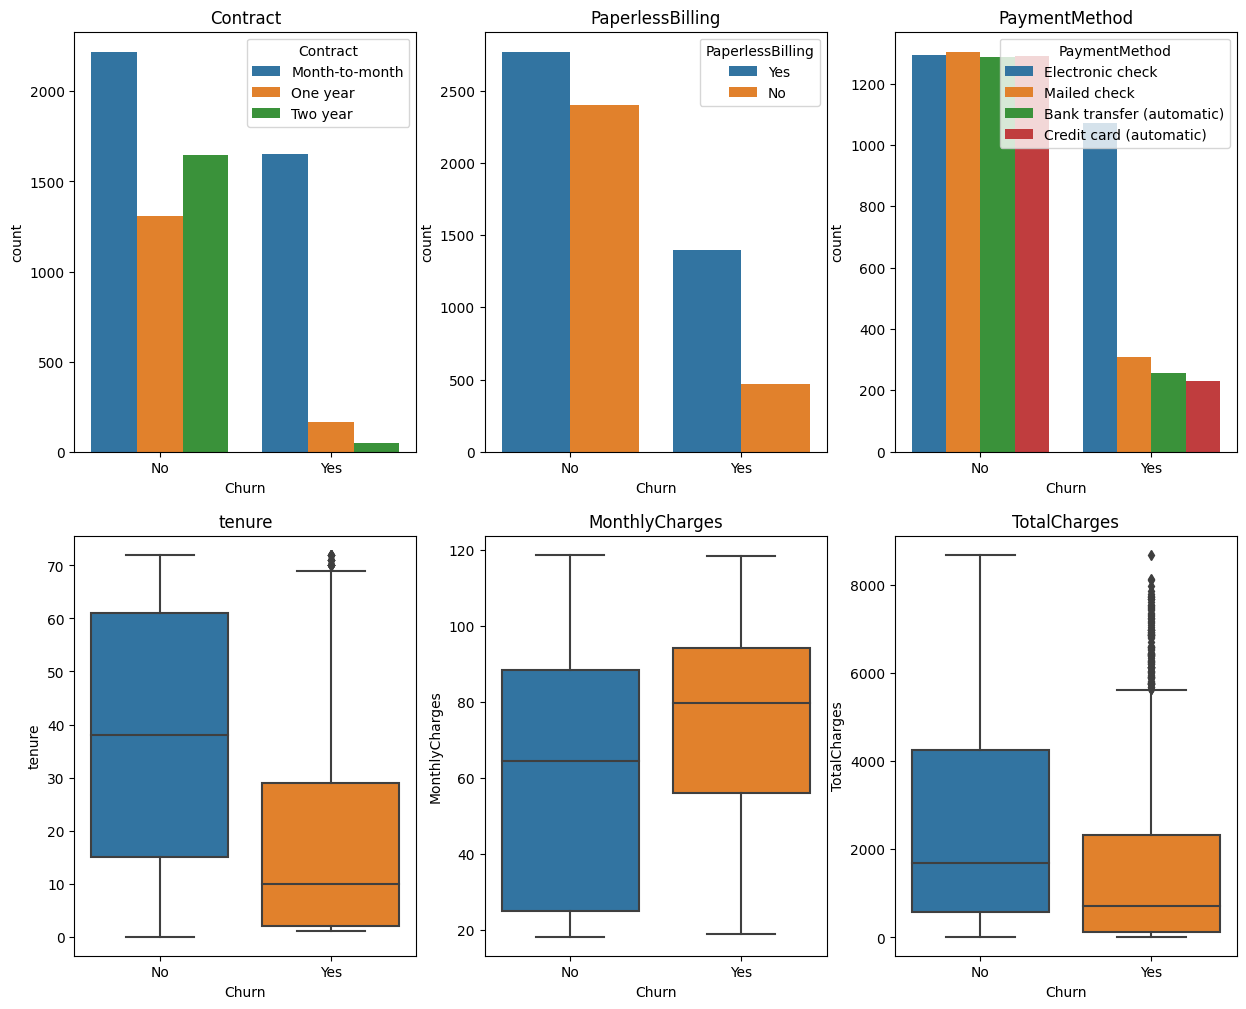

In [9]:
# Eritellään sopimustietoja käsittelevät sarakkeet
contract_info = ["Contract", "PaperlessBilling", "PaymentMethod", "tenure", "MonthlyCharges", "TotalCharges"]

# Luodaan kuvaajat jokaiselle sarakkeelle. Kategorisia ja numeerisia sarakkeita varten on luotu omat for-loopit.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 12))

for index, axis in enumerate(axes[0].flatten()):
    sns.countplot(x="Churn", hue=str(contract_info[index]), data=df, ax=axis)
    axis.set_title(str(contract_info[index]))

for index, axis in enumerate(axes[1].flatten()):
    sns.boxplot(x="Churn", y=str(contract_info[index + 3]), data=df, ax=axis)
    axis.set_title(str(contract_info[index + 3]))

<AxesSubplot: xlabel='tenure', ylabel='count'>

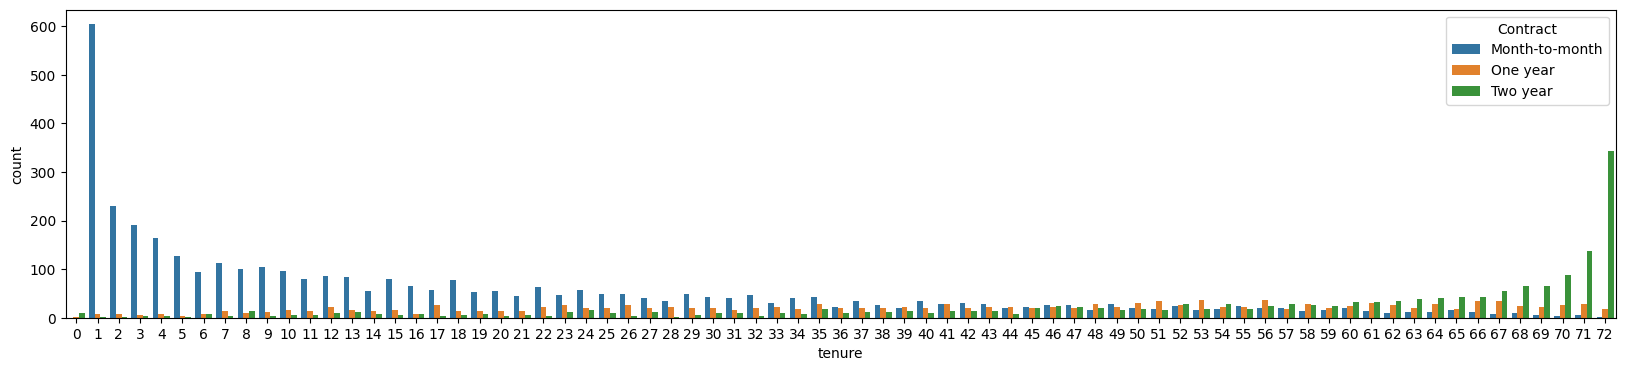

In [10]:
plt.figure(figsize=(20,4))

ax = plt.subplot(1, 1, 1)
sns.countplot(x="tenure", hue="Contract", data=df)

    Huomioita
- Toistaiseksi voimassa olevalla sopimuksella olevat asiakkaat ovat irtisanoneet sopimuksensa huomattavasti herkemmin, kuin määräaikaisilla sopimuksilla olevat. On toki luonnollista, että lyhyemmän kestoisella sopimuksella olevien asiakkaiden poistuma on suurempi, mutta poistuneiden asiakkaiden osuus on silti huomattavan suuri.
- Pidempiaikaisista asiakkaista valtaosalla on kahden vuoden määräaikainen sopimus. Vastaavasti valtaosalla lyhytaikaisista asiakkaista on toistaiseksi voimassa oleva sopimus, mikä selittää heidän suurta poistuman määrää.
- E-laskulla olevat asiakkaat ovat poistuneet huomattavasti useammin kuin suoraveloituksella olevat asiakkaat.
- Pidempiaikaiset asiakkaat todennäköisesti myös pysyvät asiakkaina jatkossakin.
- Lähteneiden asiakkaiden kuukausiveloitus on ollut korkeampi kuin jääneiden asiakkaiden.

##### Sopimuksiin kuuluvien palvelujen tiedot

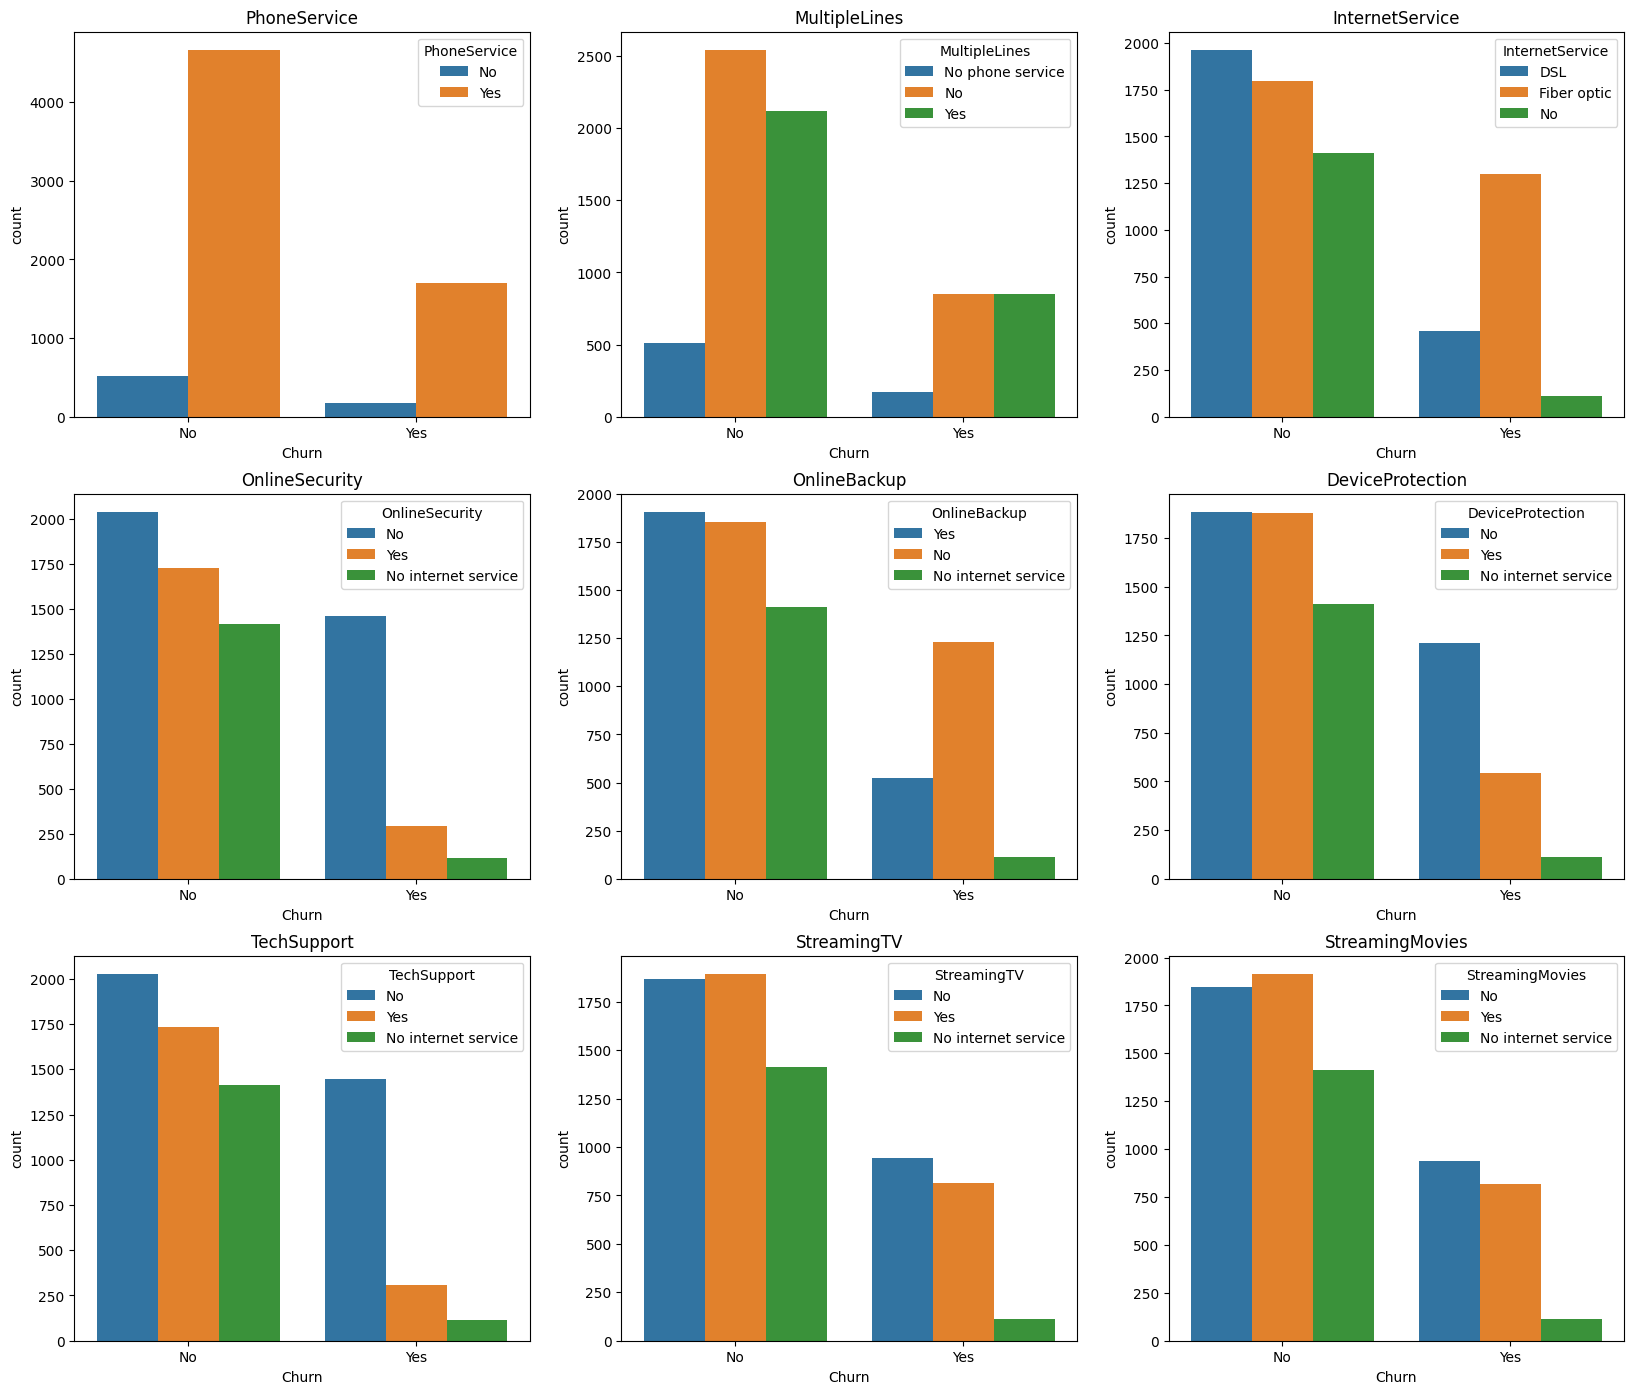

In [11]:
# Eritellään sopimukseen kuuluvia palveluita kuvaavat sarakkeet.
service_cols = ["PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

# Luodaan kuvaajat
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 17))

for index, axis in enumerate(axes.flatten()):
    sns.countplot(x="Churn", hue=str(service_cols[index]), data=df, ax=axis)
    axis.set_title(str(service_cols[index]))

    Huomioita
- Puhelinpalveluilla ei näytä olevan suurta merkitystä asiakaspoistumaan.
- Valokuitunetin omaavista asiakkaista suuri osa on poistunut.
- Asiakkaista, joilla ei ole lisäpalveluita, kuten laiteturvaa tai teknistä tukea nettiliittymässään ovat poistuneet todennäköisemmin.

### Datan jalostaminen

Datasettiä on esikäsitelty jo ennen visualisointeja, mutta mallin luomiseksi täytyy vielä:
- Tarkastella asiakaspoistuman kannalta merkittävimpiä muuttujia
- Muuttaa kategoriset attribuutit numeerisiksi
- Skaalata numeeriset muuttujat ennustusmallin luovan koneoppimisalgoritmin tehostamiseksi.

#### Merkittävimpien muuttujien tarkastelu

Tarkastellaan merkittävimpiä muuttujia [Mutual Information](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mutual_info_score.html) –arvon avulla.

In [12]:
# Funktio, joka laskee MI-arvon (Mutual Information) datasetin kategoristen muuttujien ja kohdemuuttujan välillä
def calculate_mi_score(cat_series):
    return mutual_info_score(cat_series, df.Churn)

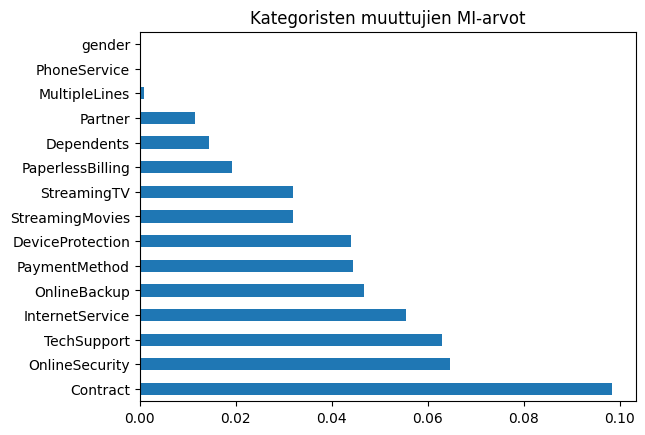

In [13]:
# Muodostetaan kategoriset sarakkeet lukuunottamatta asiakaspoistumaa sekä asiakasID:tä.
cat_cols = df.select_dtypes(include=object).drop(["Churn", "customerID"], axis=1)

# Lasketaan MI-arvot, ja esitetään ne pylväsdiagrammissa.
mi_scores = cat_cols.apply(calculate_mi_score).sort_values(ascending=False)

mi_scores.plot(kind="barh", title="Kategoristen muuttujien MI-arvot")
plt.show()

Huomataan, että puhelinpalveluihin liittyvät muuttujat sekä sukupuoli eivät näytä vaikuttavan asiakaspoistumaan, mikä oli havaittavissa myös aiemmissa visualisoinneissa. Koska ne eivät näytä tarjoavan hyödyllistä tietoa asiakaspoistuman ennustamiseen, niitä ei oteta mukaan mallin luomiseen.

#### Kategoristen attribuuttien muuttaminen

Muutetaan aluksi kategoriset attribuutit numeerisiksi.

In [14]:
# Luodaan jälleen kopio dataframesta
df_transformed = df.copy()

# Poistetaan nyt muuttujat, joita ei tarvita mallin luomisessa.
df_transformed.drop(["customerID", "MultipleLines", "PhoneService", "gender"], axis=1, inplace=True)

# Eritellään kategoriset attribuutit (paitsi customerID, koska sitä ei tarvita ennusteessa).
le = preprocessing.LabelEncoder()
categorical_columns = df_transformed.select_dtypes(include=object).columns

# Lisätään dataframeen jokaista kategorista attribuuttia kohden sitä vastaava numerokoodattu attribuutti.
for column in list(categorical_columns):
    df_transformed[column + "_encoded"] = le.fit_transform(df[column])

# Tulostetaan 10 ensimmäistä riviä.
df_transformed.head(10)

,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,OnlineSecurity_encoded,OnlineBackup_encoded,DeviceProtection_encoded,TechSupport_encoded,StreamingTV_encoded,StreamingMovies_encoded,Contract_encoded,PaperlessBilling_encoded,PaymentMethod_encoded,Churn_encoded
0,0,Yes,No,1,DSL,No,Yes,No,No,No,...,0,2,0,0,0,0,0,1,2,0
1,0,No,No,34,DSL,Yes,No,Yes,No,No,...,2,0,2,0,0,0,1,0,3,0
2,0,No,No,2,DSL,Yes,Yes,No,No,No,...,2,2,0,0,0,0,0,1,3,1
3,0,No,No,45,DSL,Yes,No,Yes,Yes,No,...,2,0,2,2,0,0,1,0,0,0
4,0,No,No,2,Fiber optic,No,No,No,No,No,...,0,0,0,0,0,0,0,1,2,1
5,0,No,No,8,Fiber optic,No,No,Yes,No,Yes,...,0,0,2,0,2,2,0,1,2,1
6,0,No,Yes,22,Fiber optic,No,Yes,No,No,Yes,...,0,2,0,0,2,0,0,1,1,0
7,0,No,No,10,DSL,Yes,No,No,No,No,...,2,0,0,0,0,0,0,0,3,0
8,0,Yes,No,28,Fiber optic,No,No,Yes,Yes,Yes,...,0,0,2,2,2,2,0,1,2,1
9,0,No,Yes,62,DSL,Yes,Yes,No,No,No,...,2,2,0,0,0,0,1,0,0,0


Nyt käytössä on dataframe, jossa on tallella alkuperäiset kategoriset muuttujat, sekä uudet niitä vastaavat numeeriset muuttujat.

#### Numeeristen muuttujien skaalaus

Seuraavaksi skaalataan numeeriset muuttujat. Datasetti skaalataan kolmella eri menetelmällä, jotta voidaan verrata niiden vaikutusta mallien tuloksiin. Käytettävät skaalausmenetelmät ovat [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html), [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) sekä [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

Koulutusdatan luomisessa korjataan aiemmin mainittu asiakaspoistuman epätasapaino käyttämällä **[SMOTE–menetelmää](https://towardsdatascience.com/smote-fdce2f605729) (Synthetic Minority Over-sampling Technique).** 

ChatGPT määrittelee SMOTEn seuraavasti: *SMOTEn tarkoitus on syntetisoida vähemmistöluokan havaintoja luomalla uusia havaintoja sillä. Menetelmä toimii siten, että se valitsee satunnaisesti vähemmistöluokan havainnon, jonka lähempiä naapureita se valitsee, ja luo uusia havaintoja näiden naapureiden välille. Se on erityisen hyödyllinen, kun vähemmistöluokka on merkittävästi pienempi kuin enemmistöluokka.* 

In [15]:
# Eritellään koulutusdatasta poistettavat muuttujat (=kategoriset muuttujat + kohdemuuttuja eli Churn_encoded)
cols_to_remove = ['Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn', 'Churn_encoded']


In [16]:
# Tallennetaan skaalausmenetelmien nimet sekä Scaler()–objektit sanakirjaan, 
# ja luodaan lista, johon skaalatut koulutus ja testidatat voidaan tallentaa.
scalers = {"Robust Scaler" : RobustScaler(), "MinMax Scaler" : MinMaxScaler(), "Standard Scaler" : StandardScaler()}
data_versions = []

# Skaalataan numeeriset attribuutit jokaisella skaalausmenetelmällä, 
# jaetaan data koulutus- ja testisetteihin,
# sekä korjataan asiakaspoistuman epätasapainoa.
for scaler_name, scaler in scalers.items():
    splitted_data = {}
    splitted_data["Scaler Name"] = scaler_name
    X = scaler.fit_transform(df_transformed.drop(cols_to_remove, axis=1))

    splitted_data["X_train"], splitted_data["X_test"], splitted_data["y_train"], splitted_data["y_test"] = train_test_split(X, df_transformed["Churn_encoded"], test_size=0.25, random_state=42)

    oversample = SMOTE(k_neighbors=5)
    X_smote, y_smote = oversample.fit_resample(splitted_data["X_train"], splitted_data["y_train"])
    splitted_data["X_train"], splitted_data["y_train"] = X_smote, y_smote

    data_versions.append(splitted_data)


### Ennustusmallien luominen

Samaan tapaan kuin luokittelijoiden kanssa, mallien suorituskyvyn vertailun vuoksi luodaan neljä eri malliobjektia, joiden nimet ja niitä vastaavat objektit on tallennettu sanakirjaan.

Käytettävät mallit ovat: [LogisticRegression](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc), [RandomForestClassifier](https://towardsdatascience.com/understanding-random-forest-58381e0602d2), [KNeighborsClassifier](https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn) ja [DecisionTreeClassifier](https://towardsdatascience.com/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b60575).

Jokainen malli koulutetaan jokaisella eri skaalatulla koulutusdatalla, ja tulokset tallennetaan uuteen Pandas Dataframe–objektiin. Lopuksi visualisoidaan tulokset.

In [17]:
# Mallisanakirjan ja dataframen muodostamista varten tarvittavien listojen luominen.
predictive_models = {"Logistic Regression" : LogisticRegression(),
 "RandomForest Classifier" : RandomForestClassifier(n_estimators=100, max_depth=10),
 "KNeighbors Classifier" : KNeighborsClassifier(n_neighbors=2),
 "Decision Tree Classifier" : DecisionTreeClassifier(random_state=42)}

prediction_methods = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Sovitetaan skaalatut koulutusdatat ennustusmalleihin, ja lisätään oikeat arvot listoihin
for data_version in data_versions:
    for model_name, predictive_model in predictive_models.items(): 
        model = predictive_model
        model.fit(data_version["X_train"], data_version["y_train"])

        y_pred = model.predict(data_version["X_test"])
        
        prediction_methods.append(data_version["Scaler Name"] + " with " + model_name)
        accuracies.append(accuracy_score(data_version["y_test"], y_pred))
        precisions.append(precision_score(data_version["y_test"], y_pred))
        recalls.append(recall_score(data_version["y_test"], y_pred))
        f1_scores.append(f1_score(data_version["y_test"], y_pred))


In [18]:
# Muodostetaan tulokset sisältävä Dataframe.
result_data = {"Prediction method" : prediction_methods,
                "Accuracy" : accuracies,
                "Precision" : precisions,
                "Recall" : recalls,
                "F1 Score" : f1_scores}

result_df = pd.DataFrame(result_data)
result_df

,Prediction method,Accuracy,Precision,Recall,F1 Score
0,Robust Scaler with Logistic Regression,0.761499,0.539919,0.832985,0.655172
1,Robust Scaler with RandomForest Classifier,0.772856,0.563607,0.730689,0.636364
2,Robust Scaler with KNeighbors Classifier,0.731970,0.508235,0.450939,0.477876
3,Robust Scaler with Decision Tree Classifier,0.704713,0.464957,0.567850,0.511278
4,MinMax Scaler with Logistic Regression,0.756388,0.533512,0.830898,0.649796
5,MinMax Scaler with RandomForest Classifier,0.784781,0.581169,0.747390,0.653881
6,MinMax Scaler with KNeighbors Classifier,0.733106,0.510638,0.450939,0.478936
7,MinMax Scaler with Decision Tree Classifier,0.731970,0.506446,0.574113,0.538160
8,Standard Scaler with Logistic Regression,0.760363,0.538255,0.837161,0.655229
9,Standard Scaler with RandomForest Classifier,0.783646,0.579288,0.747390,0.652689


In [19]:
print(result_df.loc[result_df["Accuracy"].idxmax()])

Prediction method    MinMax Scaler with RandomForest Classifier
Accuracy                                               0.784781
Precision                                              0.581169
Recall                                                  0.74739
F1 Score                                               0.653881
Name: 5, dtype: object


Kuten yllä on nähtävissä, saatiin 12 rivinen dataframe, jonka yksi rivi sisältää käytetyn ennustusmetodin kuvauksen sekä sen suorituskykymittarit. Paras ennustustarkkuus *(0,785)* saatiin, kun käytettiin MinMax–skaalausmenetelmää ja RandomForest–luokittelijaa.

### Tulosten arviointi ja visualisointi

Järjestetään tulostaulukko laskevaan järjestykseen seruaavan hierarkian mukaisesti:
1. Accuracy
2. F1 Score
3. Precision
4. Recall.

Järjestämisen jälkeen visualisoidaan tulokset pylväskuvioon.

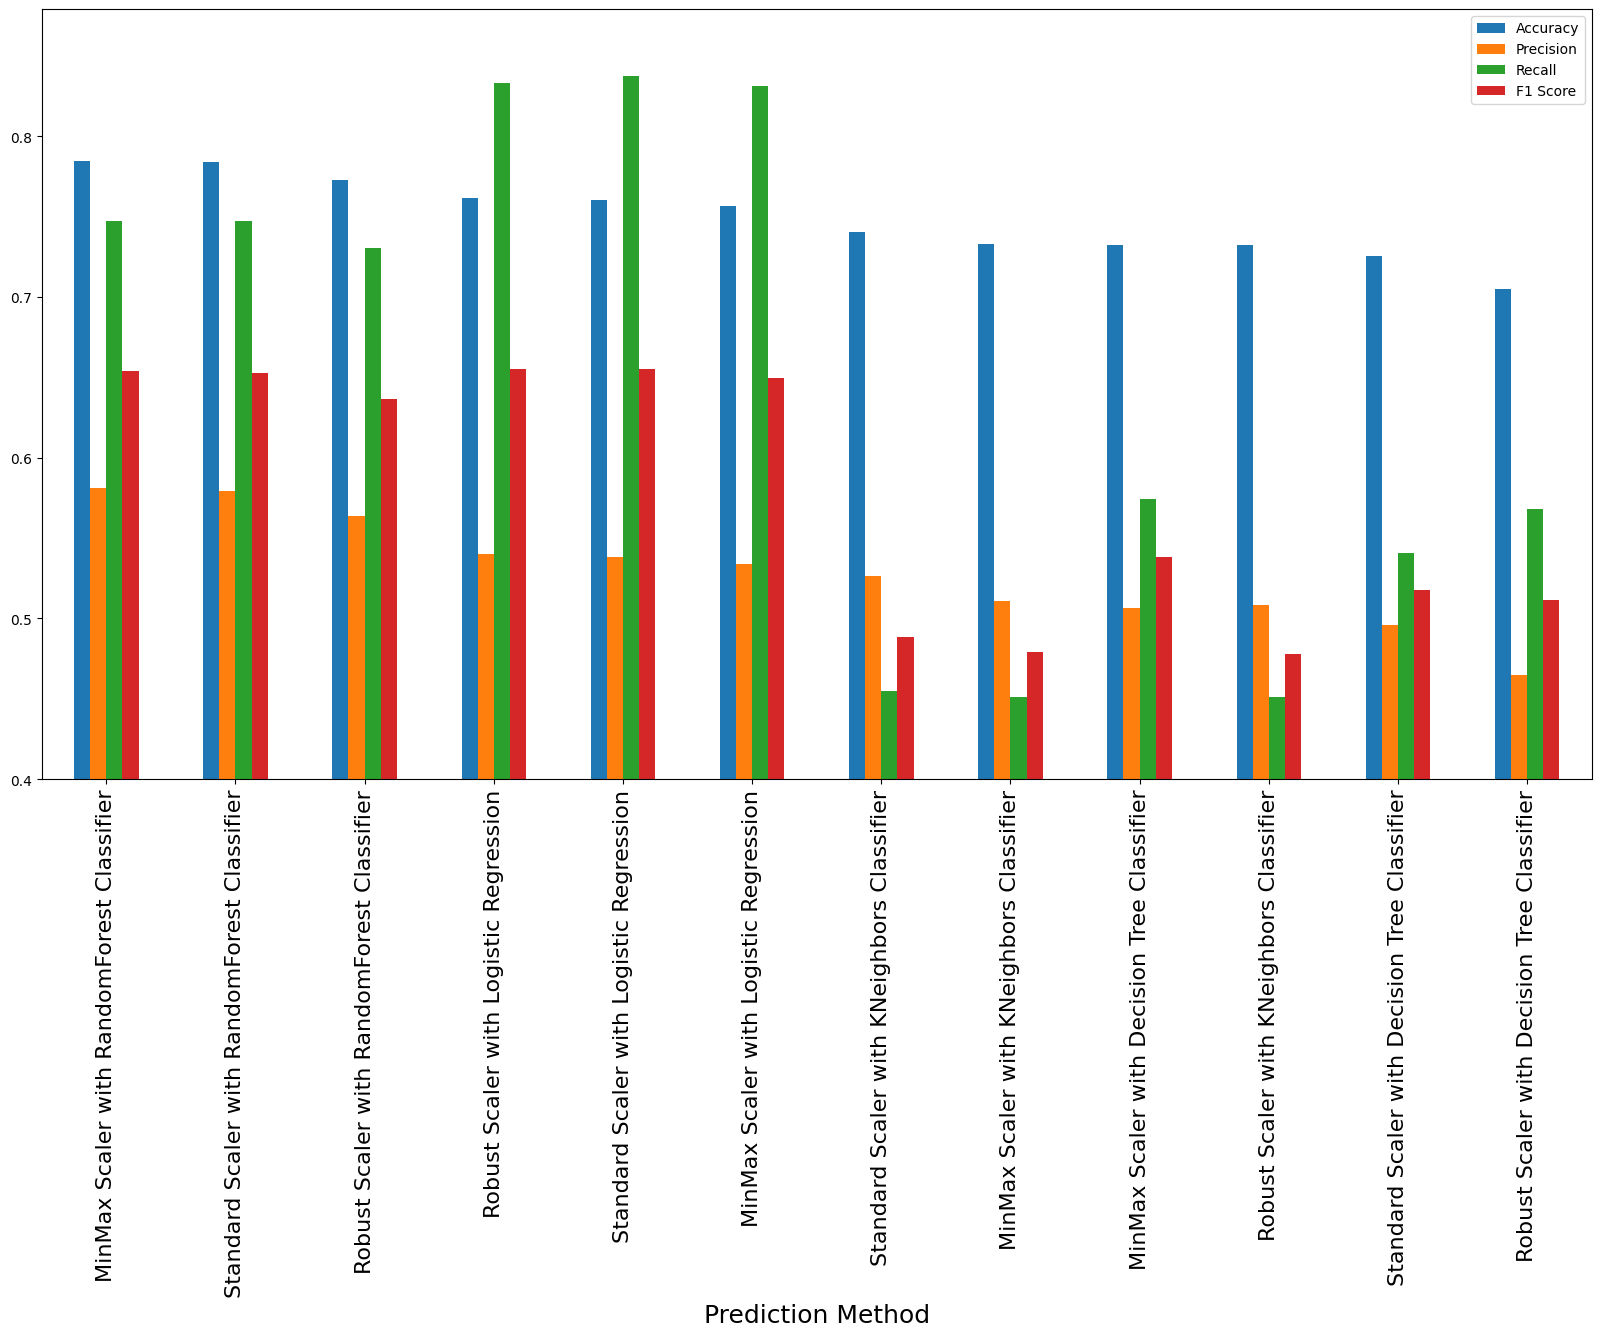

In [20]:
result_df = result_df.sort_values(by=['Accuracy', 'F1 Score', 'Precision', 'Recall'], ascending=False)

result_df.plot(x="Prediction method", y=["Accuracy", "Precision", "Recall", "F1 Score"], kind="bar", figsize=(20,10))
plt.xticks(fontsize=16)
plt.xlabel("Prediction Method", fontsize=18)
plt.ylim(0.4)
plt.show()

    Huomiota
- Paras Tarkkuusarvo saatiin käyttäen MinMax–skaalausta sekä RandomForest luokittelijaa **(Accuracy: 0,785)**
- RandomForest–luokittelija antoi ennustustarkkuuden osalta parhaimmat tulokset jokaista skaalausmetodia käyttäen.
- Decision Tree-luokittelija antoi heikoimmat tarkkuusarvot.
- Selvästi parhaimmat recall–arvot saatiin logistista regressiota käyttäen.
- Mikään skaalausmenetelmä ei parantanut merkittävästi minkään ennustusmallien suorituskykyä.
- MinMax–skaalausmenetelmä näytti antavan parhaimmat tulokset jokaisella koneoppimismallilla.*

*Huomioitavaa on, että koulutusdatan luomisessa käytettiin SMOTEa, jolloin jokaisella koodin ajamiskerralla koulutusdata on erilainen. Tämä saa aikaan vaihtelua siinä, millä skaalausmenetlemällä saadaan tarkin ennustusarvo.

### Yhteenveto

#### Mitä tehtiin:
1. Luettiin kuvitteellisen teleoperaattoriyrityksen asiakasdataa csv-tiedostosta.
2. Esikäsiteltiin dataa muuttamalla datatyyppejä oikeanlaisiksi sekä korvaamalla TotalCharges-sarakkeen null-arvoja sarakkeen mediaanilla.
3. Luotiin ymmärrystä dataan visualisoimalla sen eri osa-alueita.
4. Jalostettiin dataa:
    1. Tarkastelemalla asiakaspoistuman kannalta merkittävimpiä muuttujia
    2. Muuttamalla kategoriset sarakkeet numeerisiksi
    3. Skaalaamalla numeerisia sarakkeita.
5. Luotiin ennustusmallit
6. Visualisoitiin tulokset.

#### Mallit järjestyksessä suorituskyvyn mukaan
1. RandomForest–luokittelija
2. Logistinen regressiomalli
3. KNeighbors-luokittelija
4. Decision Tree–luokittelija

Parhaan ennustustarkkuuden **0,789** antoi RandomForest–luokittelija MinMax–skaalusmenetelmällä. Lukemaa voidaan pitää suhteellisen hyvänä huomioon ottaen datatiedeprojektin laajuus sekä datalle tehdyt toimenpiteet. Ennustustarkkuutta voisi parantaa esimerkiksi keräämällä enemmän asiakasdataa. Myös datatietelijän taitojen karttuessa datasettiä pystyisi jatkokäsittelemään vielä enemmän ja laadukkaammin, mikä osaltaan myös voisi parantaa ennustustarkkuutta sekä vähentää ennustusmallien ylisovittamista.